In [6]:
# !pip install fcapy

import pandas as pd
from fcapy.context import FormalContext
import torch 

df_true = pd.read_csv('./FC-animal-true.csv',index_col=0)
df_true = df_true.astype(bool)

                                                 
K = FormalContext.from_pandas(df_true[0:20])
K


FormalContext (20 objects, 25 attributes, 216 connections)
          |crawl on the  ground|eat both plants and animals|eat fruits|eat grasses|eat leaves|...|live on land|prefer to live alone|prefer to live in groups|swim in the water|walk on the ground|
Ant       |                   X|                          X|          |           |         X|...|           X|                    |                       X|                 |                 X|
Ape       |                   X|                           |         X|           |         X|...|           X|                    |                       X|                 |                 X|
Baboon    |                   X|                          X|         X|           |          |...|           X|                    |                       X|                 |                 X|
Bat       |                    |                          X|          |           |          |...|            |                    |                       X|    

In [33]:

df_bert = pd.read_csv('./FC-region-bert-max.csv',index_col=0)

probs = df_bert.values
logprob = torch.tensor(probs)

outmap_min = logprob.min()
outmap_max = logprob.max()

# outmap_min = logprob.min(dim=1,keepdim=True)[0]
# outmap_max = logprob.max(dim=1,keepdim=True)[0]


# outmap_min = logprob.min(dim=0,keepdim=True)[0]
# outmap_max = logprob.max(dim=0,keepdim=True)[0]

# print(outmap_min.shape,outmap_max.shape)

logprob_normalized = (logprob - outmap_min) / (outmap_max - outmap_min)

logprob_sigmoid = logprob.sigmoid()

df_normalized = pd.DataFrame(logprob_normalized,columns=df_bert.columns, index=pd.Index(df_bert.index))
df_normalized = df_normalized.round(0).astype(bool)

df_sigmoid = pd.DataFrame(logprob_sigmoid,columns=df_bert.columns, index=pd.Index(df_bert.index))

df_sigmoid = df_sigmoid.round(0).astype(bool)


# K = FormalContext.from_pandas(df_normalized)
# K

# df_bert = df_bert


# df_true[0:20]

In [17]:

# logprob_normalized.max()
# probs.shape

(69, 25)

In [14]:

# print(df_normalized.astype(int).sum())

# logprob_normalized.mean()

tensor(0.5961, dtype=torch.float64)

In [40]:

import torch
from sklearn.metrics import f1_score,average_precision_score

f1s1 = []
mAPs1 = []

f1s2 = []
mAPs2 = []

for threshold in [-0.45,-0.4,-0.3,-0.2,-0.15,-0.1,-0.05,0.0, 0.05, 0.1,0.15,0.2,0.3,0.4,0.45]:
    df_normalized = pd.DataFrame(logprob_normalized+threshold,columns=df_bert.columns, index=pd.Index(df_bert.index))
    df_normalized = df_normalized.round(0).astype(float)
    f1 = f1_score(y_true=df_true.astype(int).values, y_pred=df_normalized.astype(int).values,average="weighted" )
    mAP = average_precision_score(df_true.astype(int).values, df_normalized.astype(int).values)
    f1s1.append(f1)
    mAPs1.append(mAP)

    df_sigmoid = pd.DataFrame(logprob_sigmoid+threshold,columns=df_bert.columns, index=pd.Index(df_bert.index))
    df_sigmoid = df_sigmoid.round(0).astype(float)
    f1 = f1_score(y_true=df_true.astype(int).values, y_pred=df_sigmoid.astype(int).values,average="weighted" )
    mAP = average_precision_score(df_true.astype(int).values, df_sigmoid.astype(int).values)
    f1s2.append(f1)
    mAPs2.append(mAP)
    


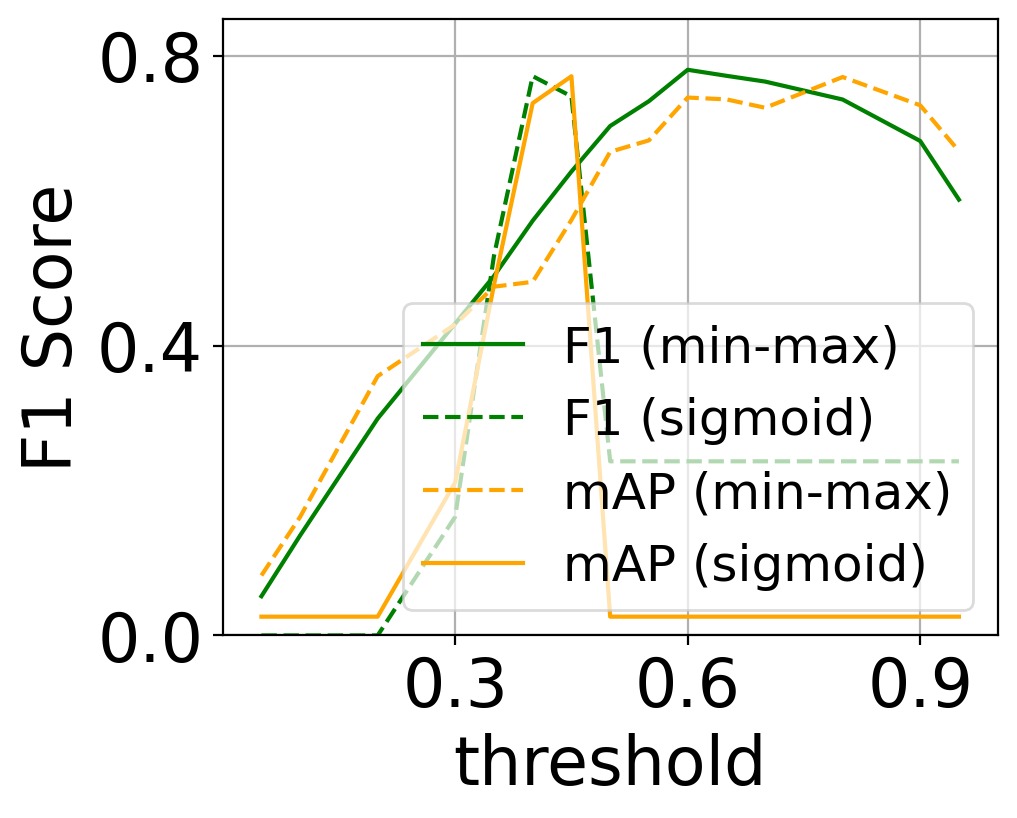

In [62]:

import matplotlib.pyplot as plt

x = [i+0.5 for i in [-0.45,-0.4,-0.3,-0.2,-0.15,-0.1,-0.05,0.0, 0.05, 0.1,0.15,0.2,0.3,0.4,0.45]]
y1 = f1s1
y2 = mAPs1

y3 = f1s2
y4 = mAPs2

# y3 = dists3

fig, ax = plt.subplots(figsize=(5, 4.0), dpi=200)

plt.plot(x,y1,label='F1 (min-max)',c='g',)
plt.plot(x,y3,label='F1 (sigmoid)',c='g',linestyle='--')

plt.plot(x,y2,label='mAP (min-max)', c='orange',linestyle='--')
plt.plot(x,y4,label='mAP (sigmoid)', c='orange')

ax.set_yticks([0.,0.4, 0.8])
ax.set_xticks([0.3, 0.6, 0.9])

plt.legend(fontsize=18,framealpha=0.7)
plt.xlabel('threshold',fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim(.0, 0.85)
plt.xlim(.0, 1.)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)


plt.grid()

plt.savefig('F1score.pdf', bbox_inches='tight', pad_inches=0, dpi=200)


# plt.plot(x,y3)


In [ ]:

# print(K.extension( ['French'] ))
# print(K.intention( ['Luxembourg', 'Germany'] ))


In [7]:

# Create the concept lattice
from fcapy.lattice import ConceptLattice
L = ConceptLattice.from_context(K)

print(len(L))

print(L.top, L.bottom)


410
0 409


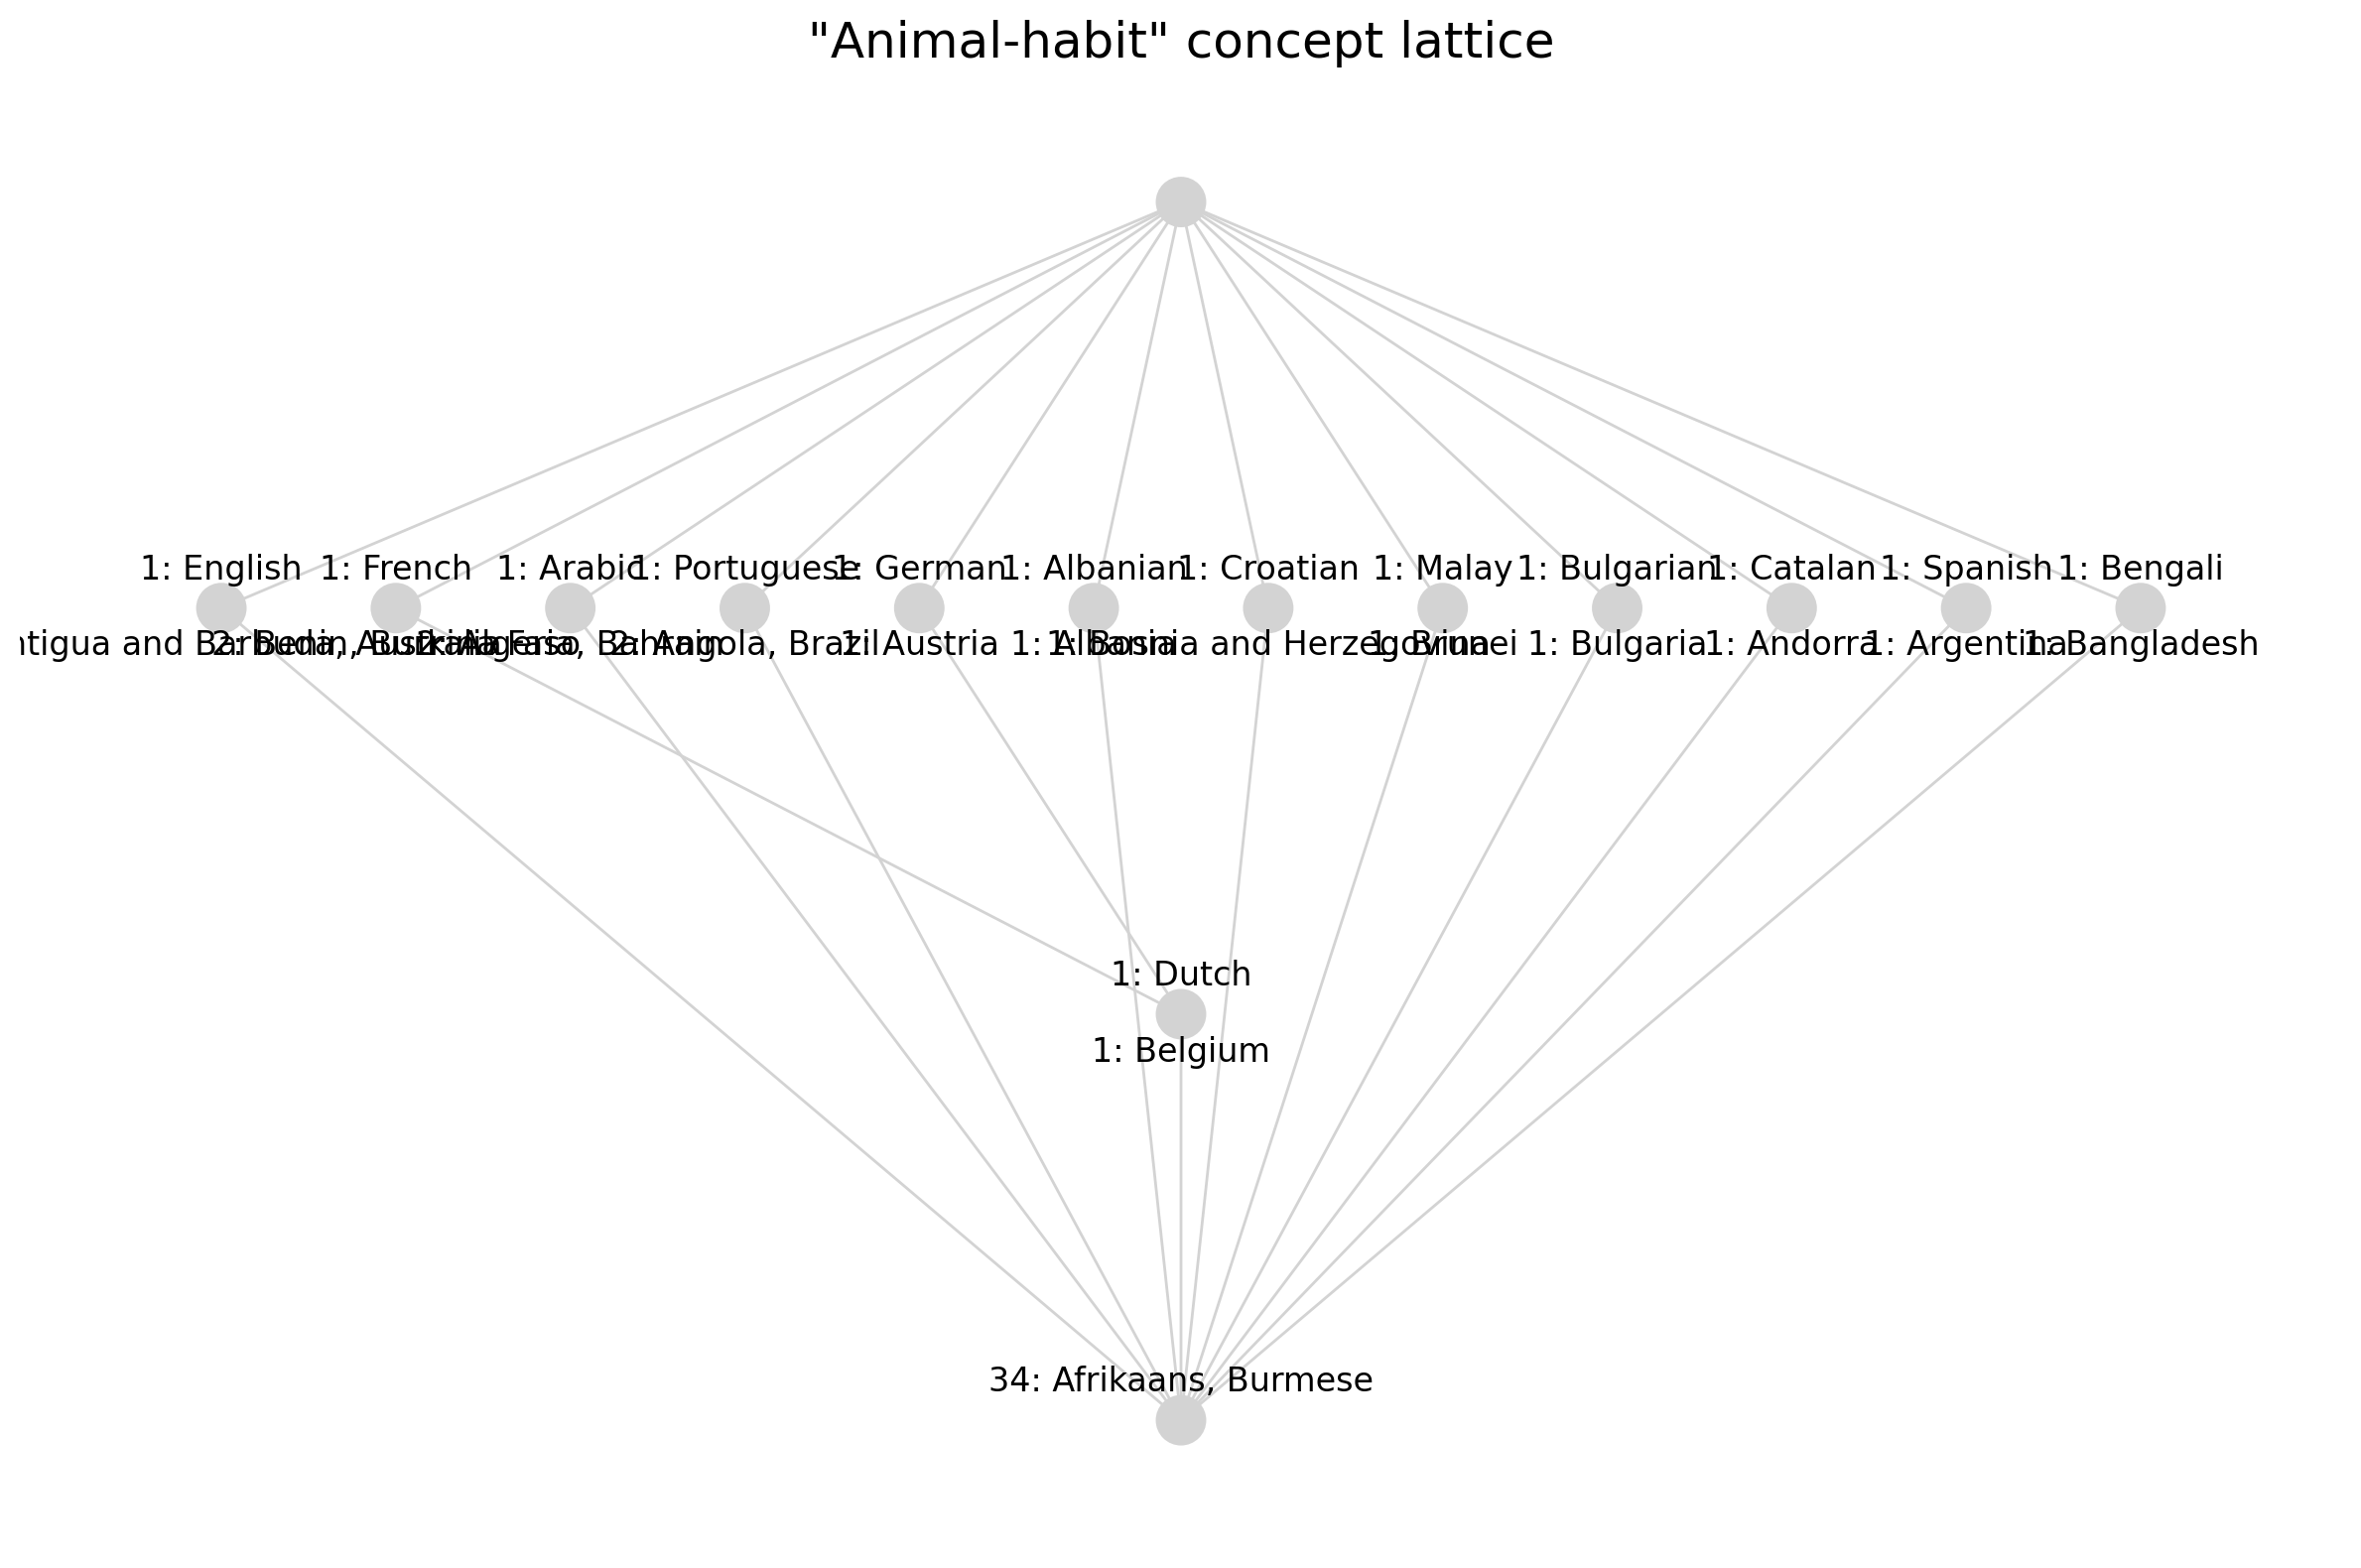

In [6]:

import matplotlib.pyplot as plt
from fcapy.visualizer import LineVizNx
fig, ax = plt.subplots(figsize=(12, 8),dpi=200)
vsl = LineVizNx(node_label_font_size=12)
vsl.draw_concept_lattice(L, ax=ax, flg_drop_bottom_concept=False, flg_node_indices=False)
ax.set_title('"Animal-habit" concept lattice', fontsize=18)
plt.tight_layout()
plt.show()



In [ ]:

from copy import deepcopy

ms_color = ('German', 'French')

def node_clr_label_func(c_i, L, ms_color=ms_color):
    lbl = LineVizNx.concept_lattice_label_func(c_i, L, flg_new_extent_count_prefix=False, flg_new_intent_count_prefix=False)
    for s in ms_color:
        lbl = lbl.replace(s, '')
    
    lbl = lbl.replace(',', '')
    if c_i not in [2,9,13,18,24,7,8,10,19,22,27,28,29] and 'French' not in lbl:
        lbl=''
    if c_i == 0:
        lbl= 'Top'
    if c_i == 63:
        lbl= 'Bottom'
    return lbl


L_clr = deepcopy(L)

# Drop a concept if it only describes the coloured attributes
# for c in L_clr[1:]:    
#     if set(c.intent)-set(ms_color) == set(L_clr.top.intent):
#         L_clr.remove(c)
    
# # Drop a concept if it does not provide neither a new intent nor a new extent
# # i.e. node label is empty
# for c in L_clr[:-1]:
#     if len(node_clr_label_func(L_clr.index(c), L_clr).strip()) == 0:
#         L_clr.remove(c) 

clr_map = {frozenset(ms_color): 'khaki', frozenset({ms_color[0]}): 'navy', frozenset({ms_color[1]}): 'forestgreen',}
node_color_legend = {
    clr_map[frozenset(ms_color)]: 'German and French',
    clr_map[frozenset({ms_color[0]})]: 'German',
    clr_map[frozenset({ms_color[1]})]: 'French',
    # clr_map[frozenset({ms_color[1]})]: 'Italian',
}

viz = LineVizNx(node_label_font_size=15)

node_color = [clr_map.get(frozenset(c.intent)&frozenset(ms_color), viz.node_color) for c in L_clr]



In [ ]:

fig, ax = plt.subplots(figsize=(10,7))

viz.draw_concept_lattice(
    L_clr, ax=ax,
    flg_node_indices=False,
    # flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False,
    flg_drop_bottom_concept=True,
    flg_drop_top_concept=True,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_clr_label_func,
)


leg = plt.legend(title='', title_fontproperties={'size': '14',}, fontsize=15, bbox_to_anchor=(0.12,0.08), loc='lower left')
leg._legend_box.align = "left"

# plt.title('"Region-language" concept lattice', size=15)
plt.tight_layout()
# plt.savefig('imgs/live_in_water_lattice_color_short.png')

plt.savefig('region-language-big.pdf', bbox_inches='tight', pad_inches=0, dpi=800)


plt.show()


In [ ]:

# [17, 23, 60, 63,50, 30, 51, 7, 8, 59, 24,46, 62, 47, 38,28, 18, 12, 4, 1]
